# CVAI Exercise Digital Photography

Most algorithms to use for digital photography are quite complex and therefor often implemented in specialized software like Adobe Lightroom or Photoshop.

In this exercise we will look as some simple examples that should also demonstrate more how to work with images in python.


In [1]:
import skimage
import numpy as np

# for displaying images in jupyter
import matplotlib as mpl
from matplotlib import pyplot as plt

# this makes the images a bit larger
mpl.rcParams['figure.dpi']= 200
plt.rcParams['figure.figsize'] = [5,4]

# plots directly in the notebook
%matplotlib inline 

# if you have a high-dpi monitor
%config InlineBackend.figure_format = 'retina' 

path = '/exchange/cvai/images/'

### Skimage package

We will use OpenCV and Skimage as image processing libraries in the exercises. Skimage integrates well with other python machine learning libraries, documentation is available at https://scikit-image.org

So we will quickly examine how we can use that to load and process images.

uint8
(512, 512, 3)


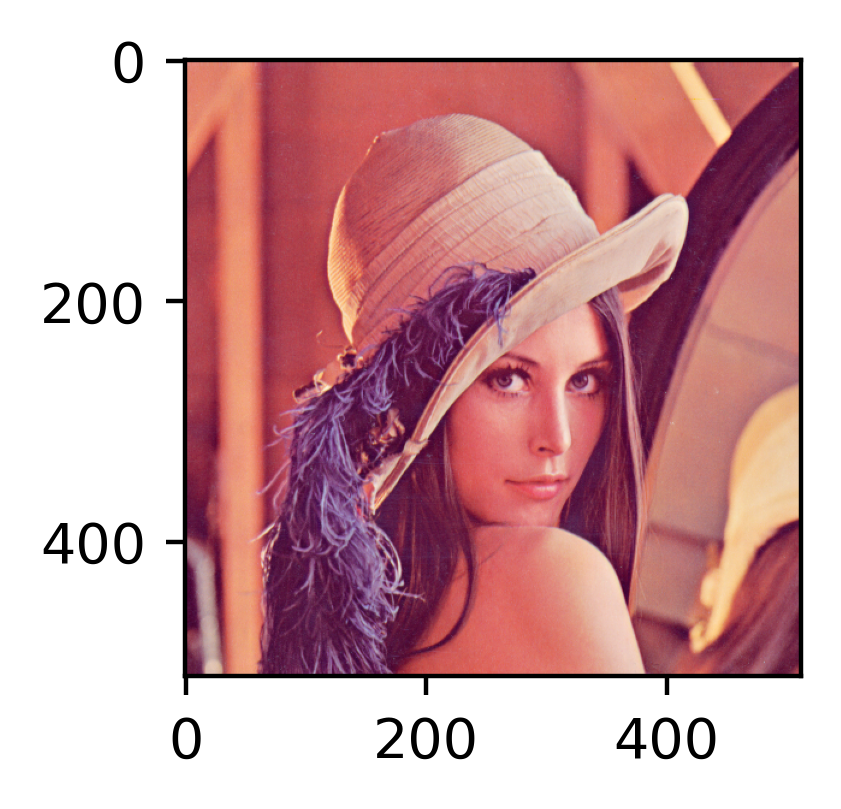

In [2]:
# images can be read using imread, this will result in a 3 channel uint8 image
image = skimage.io.imread(path + 'lena_std.tif')

plt.rcParams['figure.figsize'] = [2,2]
plt.imshow(image)
print(image.dtype)
print(image.shape)

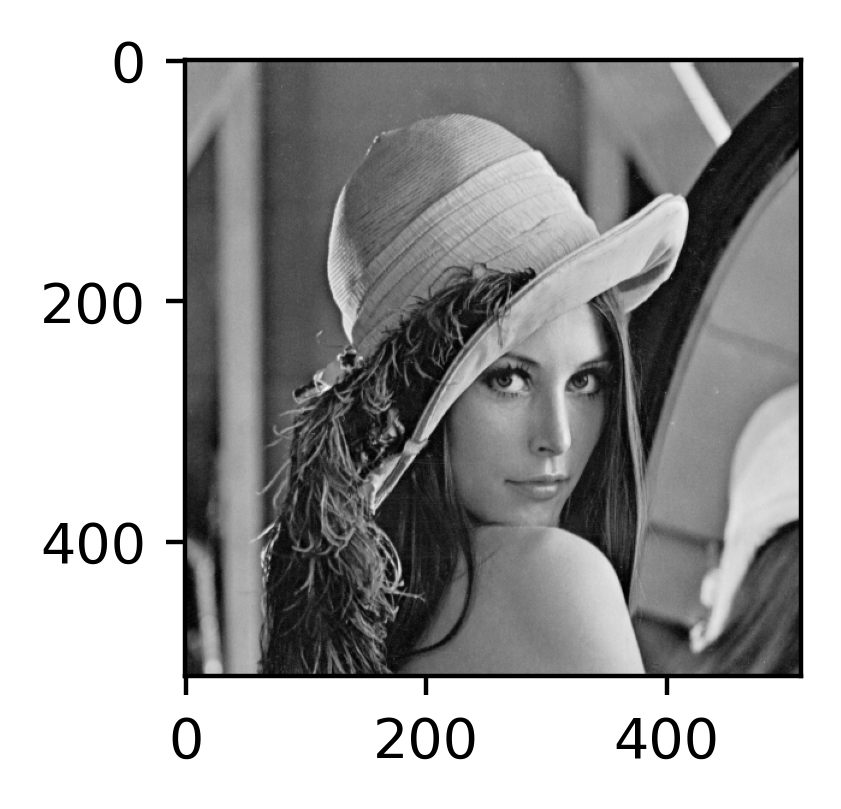

In [3]:
# there are different color transformation functions available, for example rgb2gray
# (alternatively it is als possible to read gray images directly)
image_gray = skimage.color.rgb2gray(image)
plt.imshow(image_gray, cmap='gray')

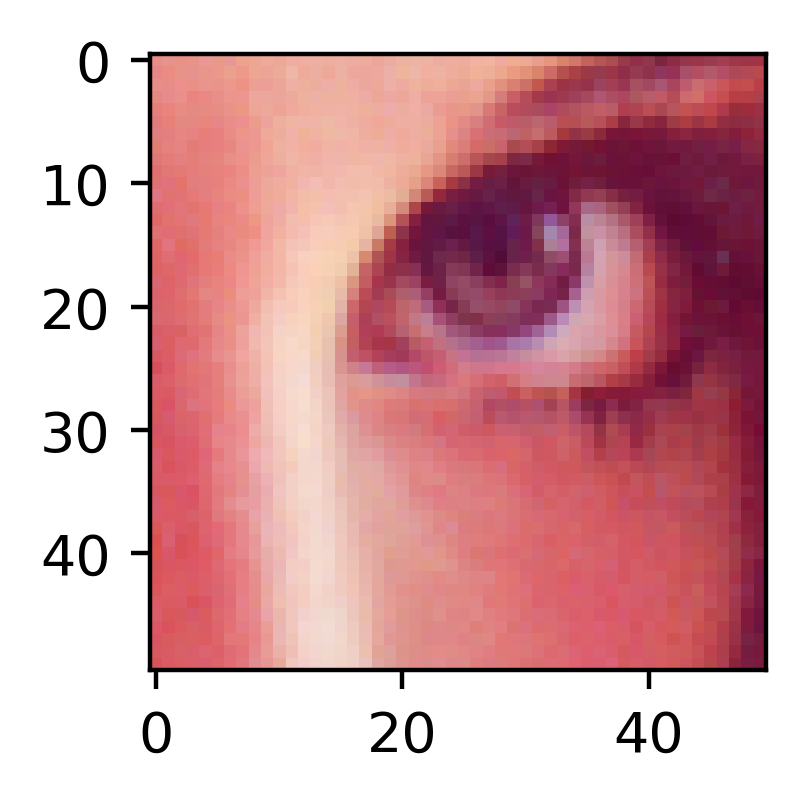

In [4]:
# we will use a closeup of the image to better see the results
detail = image[250:300,300:350,:]
plt.imshow(detail)

### Mosaicing

For the first exercise, we will look at demosaicing techniques. However instead of using a proper RAW image (those are quite large), we will instead simulate the mosaicing process on the given image.


In [5]:
def mosaic_bayer(image: np.ndarray) -> np.ndarray:
    """
    Simulate mosaicing of the given (3 channel image) using the Bayer pattern. Green is always present in each row,
    alternating with blue and red.
    The resulting image will contain a value of 0 on the masked spots.
    """
    # generate the target image of the same size as the original
    m = np.zeros_like(image)
    
    # this is not very efficient, but shows how the image is constructed
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i % 2 == 0:
                if j % 2 == 0:
                    # G
                    m[i,j,1] = image[i,j,1]
                else:
                    # B
                    m[i,j,2] = image[i,j,2]
            else:
                if j % 2 == 0:
                    # R
                    m[i,j,0] = image[i,j,0]
                else:
                    # G
                    m[i,j,1] = image[i,j,1]
    return m
            

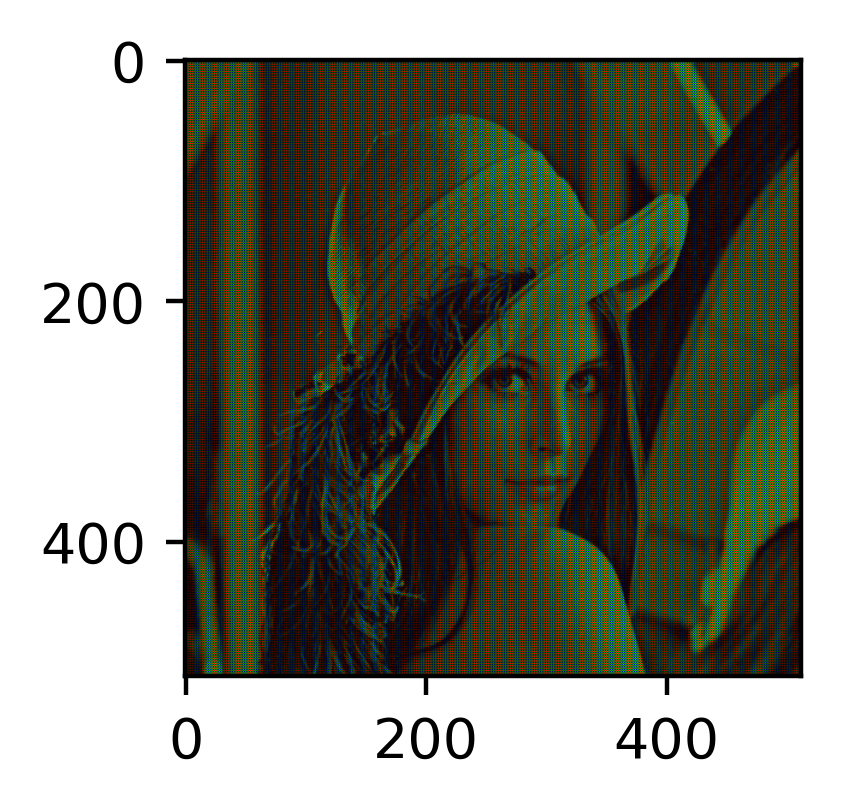

In [6]:
mosaic = mosaic_bayer(image)
plt.imshow(mosaic)

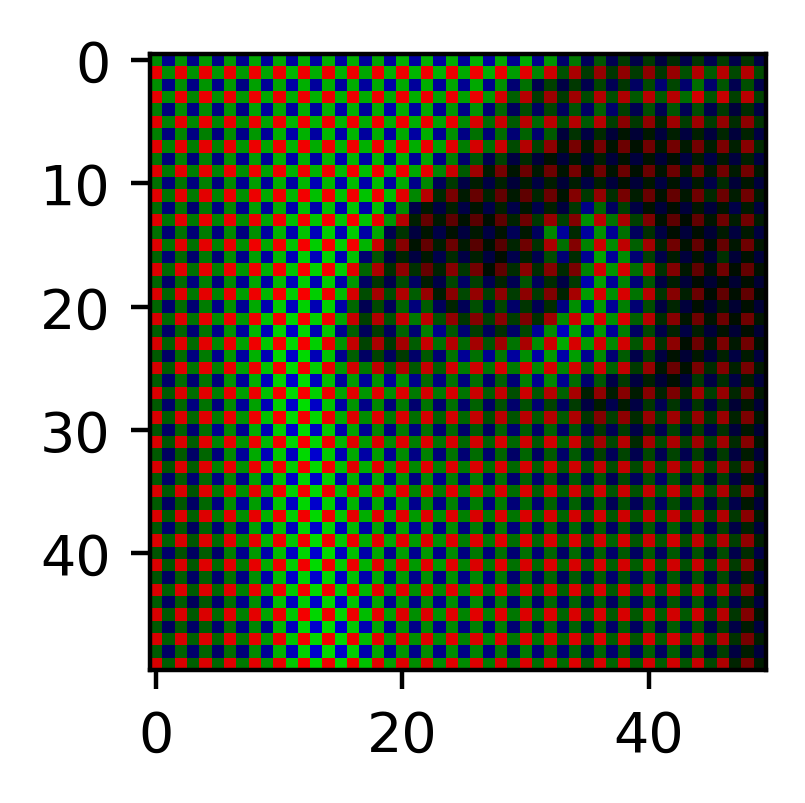

In [7]:
# let us look at a detail
mosaic_detail = mosaic[250:300,300:350,:]
plt.imshow(mosaic_detail)

## Exercise 1: Demosaicing

We would now like to reconstruct the image from the mosaic image, i.e. that is the same task that the camera must do with the output of the raw sensor data. We will implement 3 different methods and compare the results.

### Nearest Neighbor
In the first method, we will take the nearest neighbor of any color value that we do not have at a specific location. So for example, at the locations for the red pixel, we can take the green value from the neighbor to the left, and the blue value from a diagonal neighbor of the upper left. For simplification of the code, we will leave a 1-pixel border in the resulting image.

In order to get the same result as in the solution, use neighbors with lower coordinate values, i.e. for pixel (i,j) use the neighbors (i-1,j), (i,j-1) and (i-1,j-1).

Here the arrangment of the pixel values

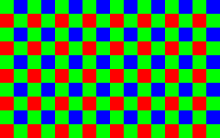

In [8]:
def demosaic_nn(image:np.ndarray)->np.ndarray:
    """
    Implement demosaicing of the input image using nearest neighbor.
    """
    # generate the target image of the same size as the original
    d = np.zeros_like(image)
  
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            
            # YOUR CODE HERE
            if i % 2 == 0:
                if j % 2 == 0:
                    # G
                    d[i,j,0] = image[i-1,j,0]
                    d[i,j,1] = image[i,j,1]
                    d[i,j,2] = image[i,j-1,2]
                else:
                    # B
                    d[i,j,0] = image[i-1,j-1,0]
                    d[i,j,1] = image[i,j-1,1]
                    d[i,j,2] = image[i,j,2]
            else:
                if j % 2 == 0:
                    # R
                    d[i,j,0] = image[i,j,0]
                    d[i,j,1] = image[i,j-1,1]
                    d[i,j,2] = image[i-1,j-1,2]
                else:
                    # G
                    d[i,j,0] = image[i,j-1,0]
                    d[i,j,1] = image[i,j,1]
                    d[i,j,2] = image[i-1,j,2]
    return d
    

In [9]:
d_nn = demosaic_nn(mosaic)
d_nn_detail = d_nn[250:300,300:350,:]

# we will check some arbitrary value for each of the 4 cases
np.testing.assert_array_equal(d_nn[260, 360,:], [86, 18, 54])
np.testing.assert_array_equal(d_nn[261, 360,:], [87, 17, 54])
np.testing.assert_array_equal(d_nn[260, 361,:], [86, 18, 61])
np.testing.assert_array_equal(d_nn[261, 361,:], [87, 26, 61])

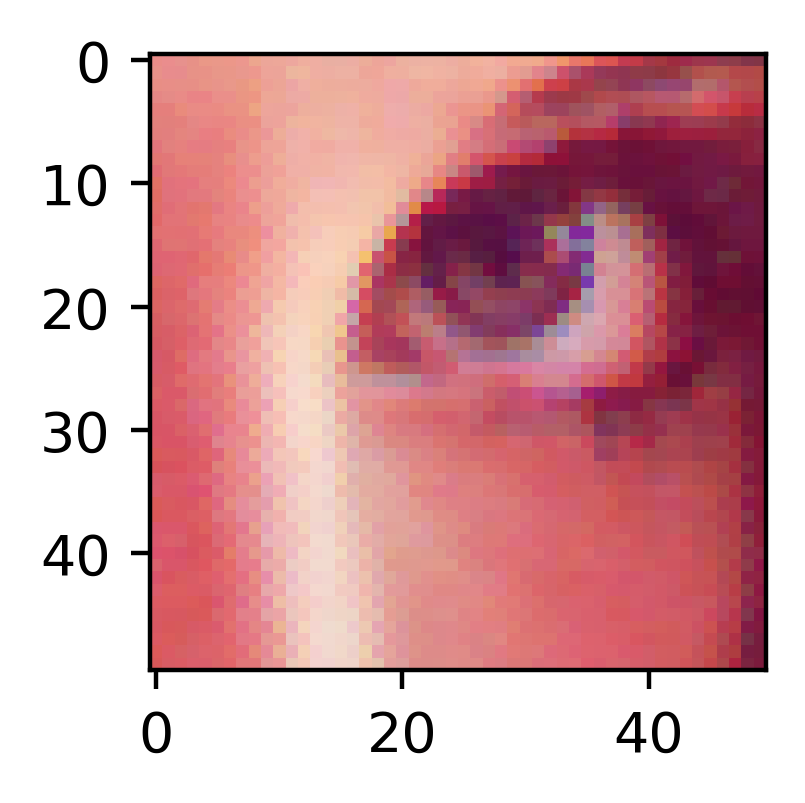

In [10]:
plt.imshow(d_nn_detail) 

### Averaging neighbors

The results are not bad, but we can see that the red and blue values have lost some of the resolution, as they
are the same in 2x2 blocks. A slightly better version, is to average each of the pixel values from the 2 or 4 nearest values. As you can see from the Bayer matrix, at the position where a green pixel is defined, the red and blue colors can be interpolated from 2 neighboring values. At the position where the green pixels are defined, 4 neighboring values can be used for red and blue.

One problem that you might have to deal with, is that the original image contains unsigned 8bit values and there might be an overflow when you add them. One possibility to deal with that, is to convert the image first to 32bit integers and do all calculation there. The resulting average should again fit into 8bit, so the result is again an 8bit image.

In [11]:
def demosaic_average(image_8bit:np.ndarray)->np.ndarray:
    """
    Implement demosaicing of the input image using averaging of 4 neighbors.
    """
    # generate the target image of the same size as the original
    d = np.zeros_like(image_8bit)
    
    # convert image to int before processing
    image = image_8bit.astype(int)

    # YOUR CODE HERE
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            if i % 2 == 0:
                if j % 2 == 0:
                    # G
                    d[i,j,0] = (image[i-1,j,0] + image[i+1,j,0]) / 2
                    d[i,j,1] = image[i,j,1]
                    d[i,j,2] = (image[i,j-1,2] + image[i,j+1,2]) / 2
                else:
                    # B
                    d[i,j,0] = (image[i-1,j-1,0] + image[i+1,j-1,0] + image[i-1,j+1,0] + image[i+1,j+1,0]) / 4
                    d[i,j,1] = (image[i,j-1,1] + image[i,j+1,1] + image[i-1,j,1] + image[i+1,j,1]) / 4
                    d[i,j,2] = image[i,j,2]
            else:
                if j % 2 == 0:
                    # R
                    d[i,j,0] = image[i,j,0]
                    d[i,j,1] = (image[i,j-1,1] + image[i,j+1,1] + image[i-1,j,1] + image[i+1,j,1]) / 4
                    d[i,j,2] = (image[i-1,j-1,2] + image[i+1,j-1,2] + image[i-1,j+1,2] + image[i+1,j+1,2]) / 4
                else:
                    # G
                    d[i,j,0] = (image[i,j-1,0] + image[i,j+1,0]) / 2
                    d[i,j,1] = image[i,j,1]
                    d[i,j,2] = (image[i-1,j,2] + image[i+1,j,2]) / 2
                
    return d

In [12]:
d_average = demosaic_average(mosaic)
d_average_detail = d_average[250:300,300:350,:]

# test values for all 4 cases
np.testing.assert_array_equal(d_average[260, 360,:], [86, 18, 57])
np.testing.assert_array_equal(d_average[261, 360,:], [87, 20, 61])
np.testing.assert_array_equal(d_average[260, 361,:], [103, 28, 61])
np.testing.assert_array_equal(d_average[261, 361,:], [102, 26, 64])

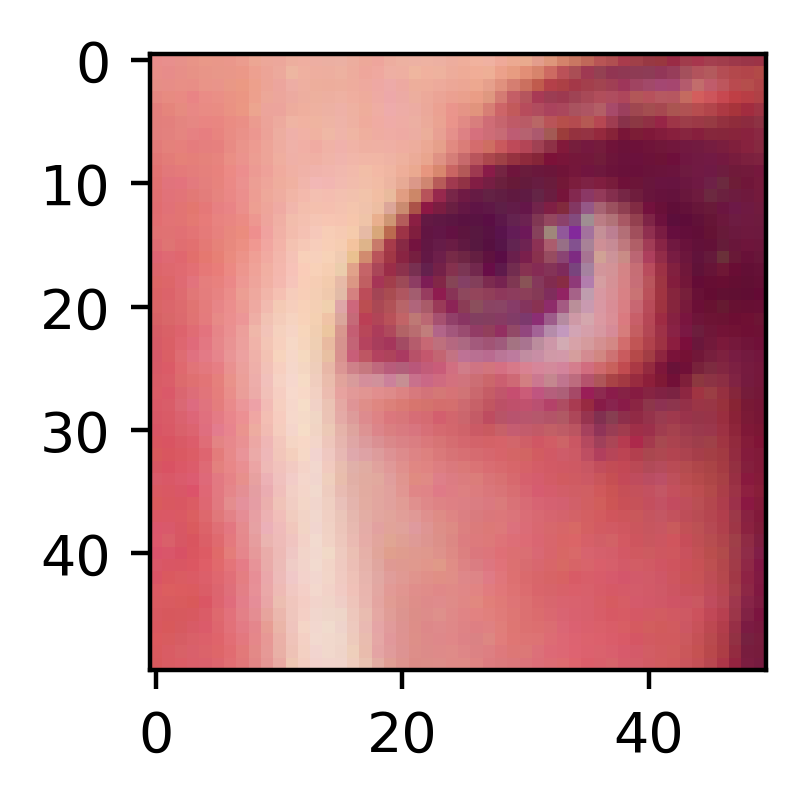

In [13]:
plt.imshow(d_average_detail) 

As we can see, the result is quite nice and smooth. Now the only problem is that it is almost too smooth, as in some places 4 pixel values were averaged. If there would be an edge at such a position, it would get blurred and the image will appear less sharp.

### Optional: Experiment with gradient techniques

So a more advanced solution that is also similar to what is done in the camera, is to determine if there is a local gradient at an image position and then use an appropriate averaging technique. If there is no gradient, we use the averaging above. If there is a strong gradient in horizontal direction (so there is a vertical edge), then we only average in the vertical direction etc.

This exercise is optional. Feel free to experiment with the idea of using gradients and see if you can obtain nicer results. Or you might want to come back to this after we have discussed gradients and edge detection a bit more in the class.

In [14]:
def demosaic_gradient(image_8bit:np.ndarray)->np.ndarray:
    """
    Implement demosaicing of the input image 
    """
    # generate the target image of the same size as the original
    d = np.zeros_like(image_8bit)
    
    # convert image to int before processing
    image = image_8bit.astype(int)
    
    # ...
    
    return d
    

## Exercise 2: Exposure and noise reduction

We will look at some simple image manipulation, again using the skimage library.

The image below has been taken in low light with a ISO setting of 10000 and with too short exposure, so it is too dark.

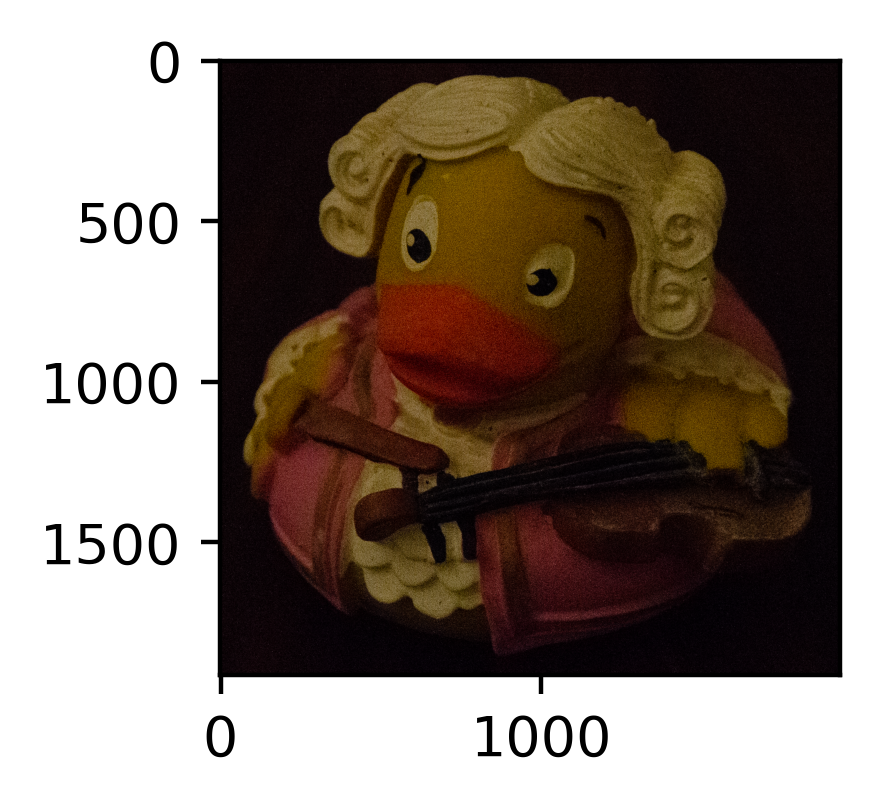

In [15]:
duck_1 = skimage.io.imread(path + 'DSC_7757.tif')
plt.imshow(duck_1)

The first task is too make it brighter. In the exposure module of the skimage library

https://scikit-image.org/docs/dev/api/skimage.exposure.html

there are some functions that could help, or it could be done directly in numpy. Change the image so that the brightest value as full brightness and store the result in a variable duck_bright.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


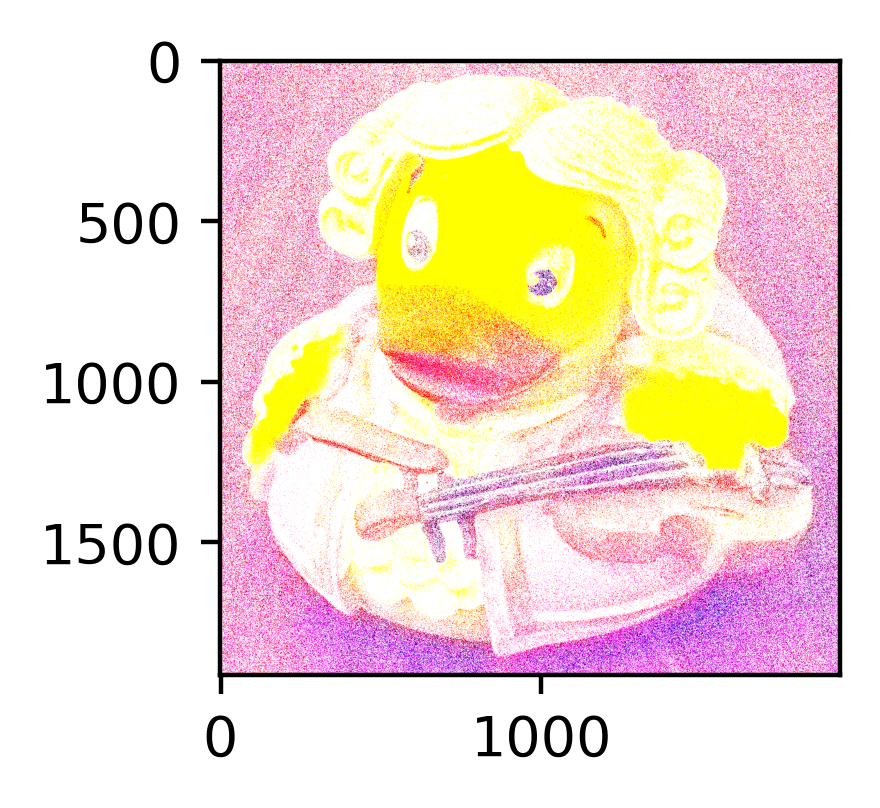

In [16]:
# calculate a brighter version of the image and store it in a variable duck_bright
# you might want to try different approaches

# YOUR CODE HERE
duck_bright = skimage.exposure.rescale_intensity(duck_1, in_range='image', out_range=(0, 255))
plt.imshow(duck_bright)

In [17]:
# we should use the whole color range normally for an image, except if there are some 
# special effects to achieve, so we want the maximum value to be 255 and the average to be brighter

assert np.max(duck_bright) == 255
assert np.average(duck_bright) > np.average(duck_1)

If you found a function to make the image brigher, it should probably be ok now. However, as the ISO value was very high, the image is very noisy. We would like to picture the noise. There are some advanced methods to estimate noise from a single image (see https://people.csail.mit.edu/billf/publications/Noise_Estimation_Single_Image.pdf), but the simplest method is to find a region with approximate constant color and plot the value distribution. Lets do that for the top right region in the image.

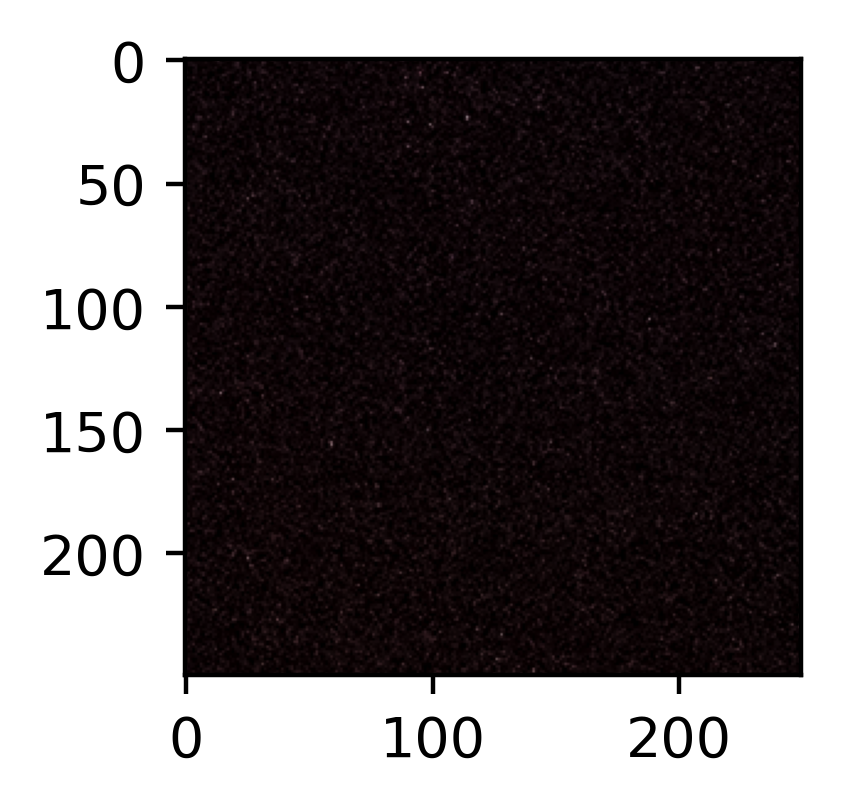

In [18]:
roi = duck_1[0:250,-250:,:]
plt.imshow(roi)

We can also display it as a line graph for all the pictures, and of course we could calculate the std deviation.

8.63595808010576


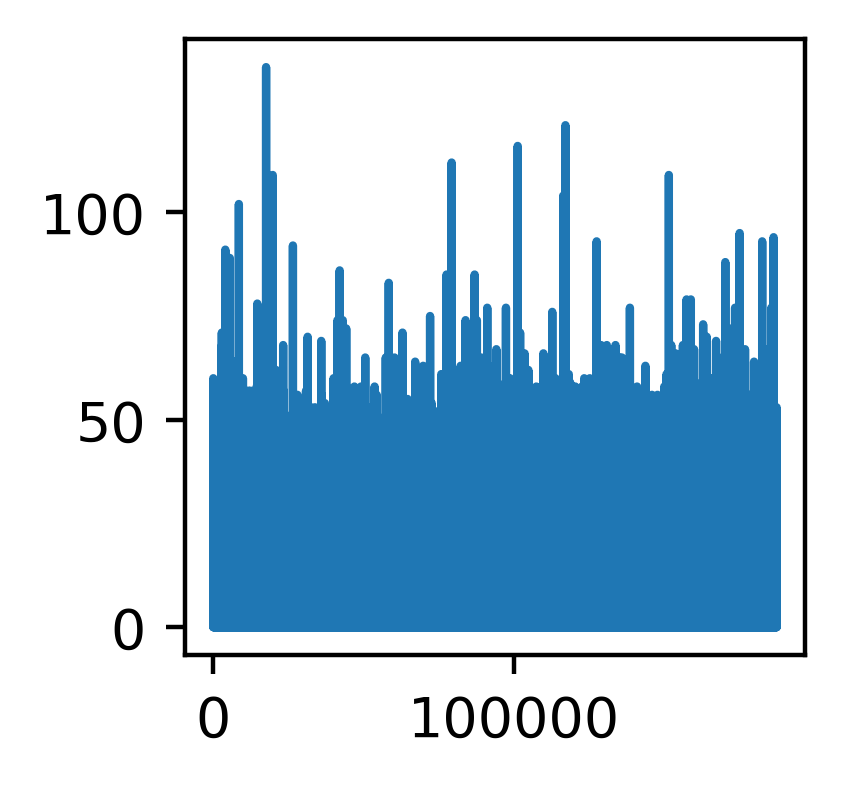

In [19]:
roi_1d = roi.reshape(-1)
print(np.std(roi_1d))
plt.plot(roi_1d)

### Noise reduction

If the noise is caused by the sensor, then it would change with each picture that we take, even if the other settings are the same. So if we have multiple images, we can combine them to create a better image with less noise.

Implement a function that takes a list of images and combines them. In the cell below, your function will be called with a total of 10 images similarly to the one above.

In [20]:
def combine_images(image_list)-> np.ndarray:
    """
    Combine the images in the list to produce a better image.
    """
    
    # YOUR CODE HERE
    combined_image = np.zeros_like(image_list[0], dtype=np.float32)

    for image in image_list:
        combined_image += image.astype(np.float32)

    combined_image /= len(image_list)

    return np.clip(combined_image, 0, 255).astype(np.uint8)
    

In [21]:
duck_names = [path + 'DSC_7757.tif',
              path + 'DSC_7758.tif',
              path + 'DSC_7759.tif',
              path + 'DSC_7760.tif',
              path + 'DSC_7761.tif',
              path + 'DSC_7762.tif',
              path + 'DSC_7763.tif',
              path + 'DSC_7764.tif',
              path + 'DSC_7765.tif',
              path + 'DSC_7766.tif']
duck_images = skimage.io.imread_collection(duck_names)

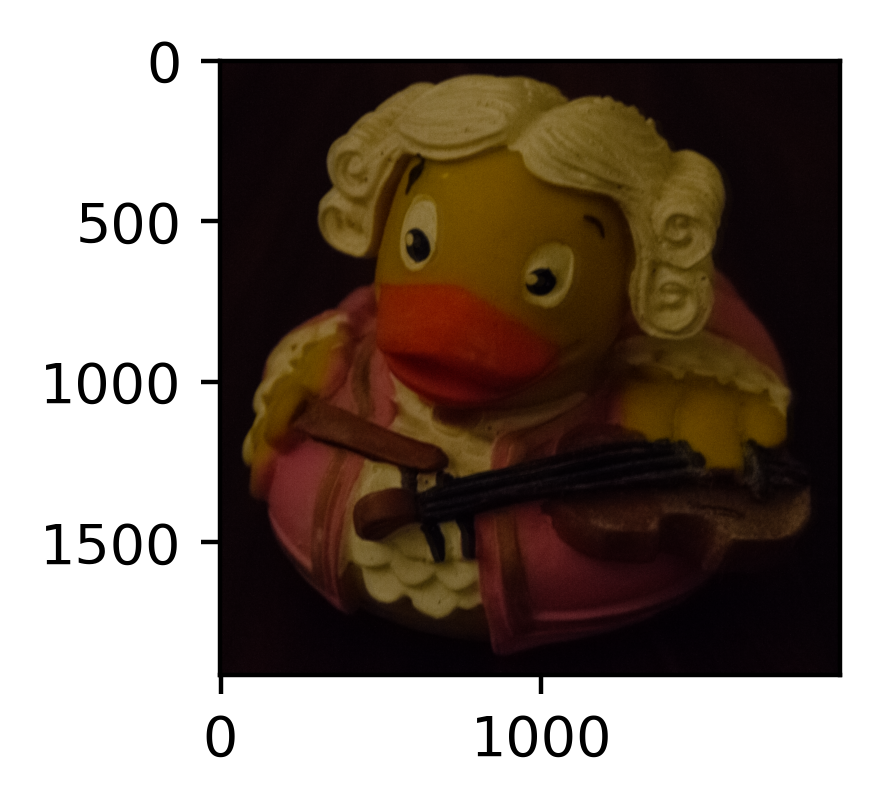

In [22]:
duck_combined = combine_images(duck_images)
plt.imshow(duck_combined)

The picture will still be a bit noisy, as there were only 10 images, but should be better than any of the single images. In order to get a nicer picture, you would have to take even more images.

We will quickly look at the noise distribution as before and see if the std has gone down.

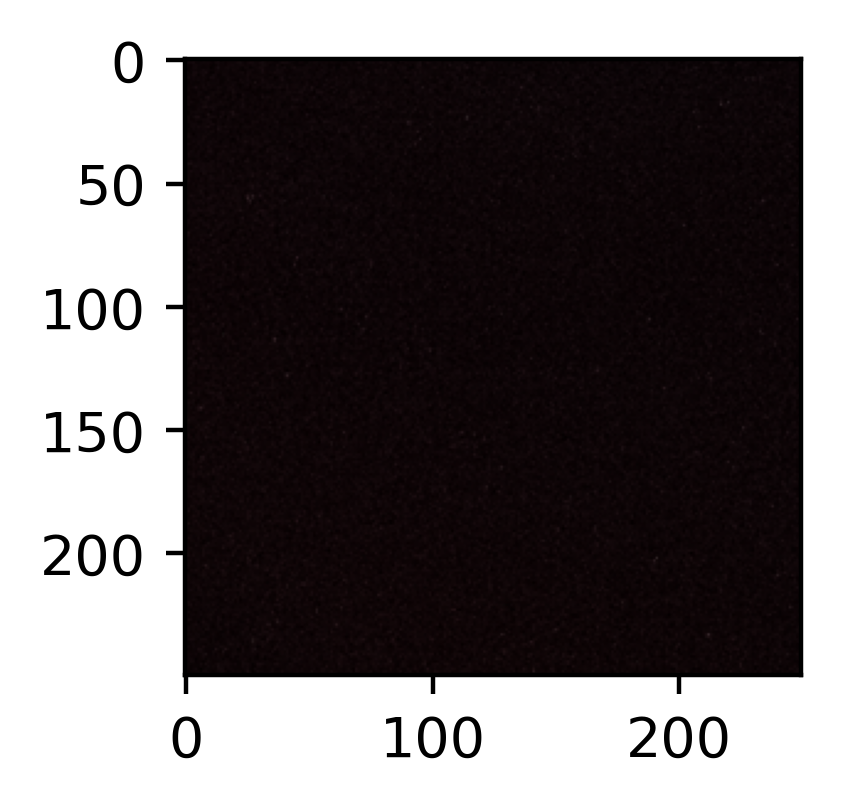

In [23]:
roi_combined = duck_combined[0:250,-250:,:]
plt.imshow(roi_combined)

4.612830846789373


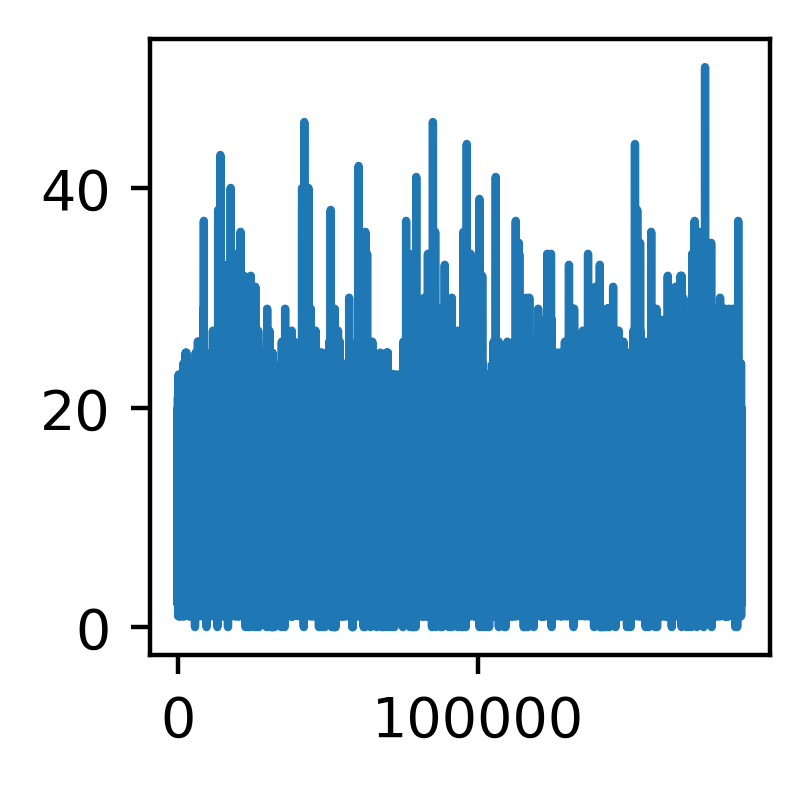

In [24]:
print(np.std(roi_combined))
plt.plot(np.reshape(roi_combined, -1))


Finally, we can make the combined image also a bit brighter again and display it. That will be all for the exercise.

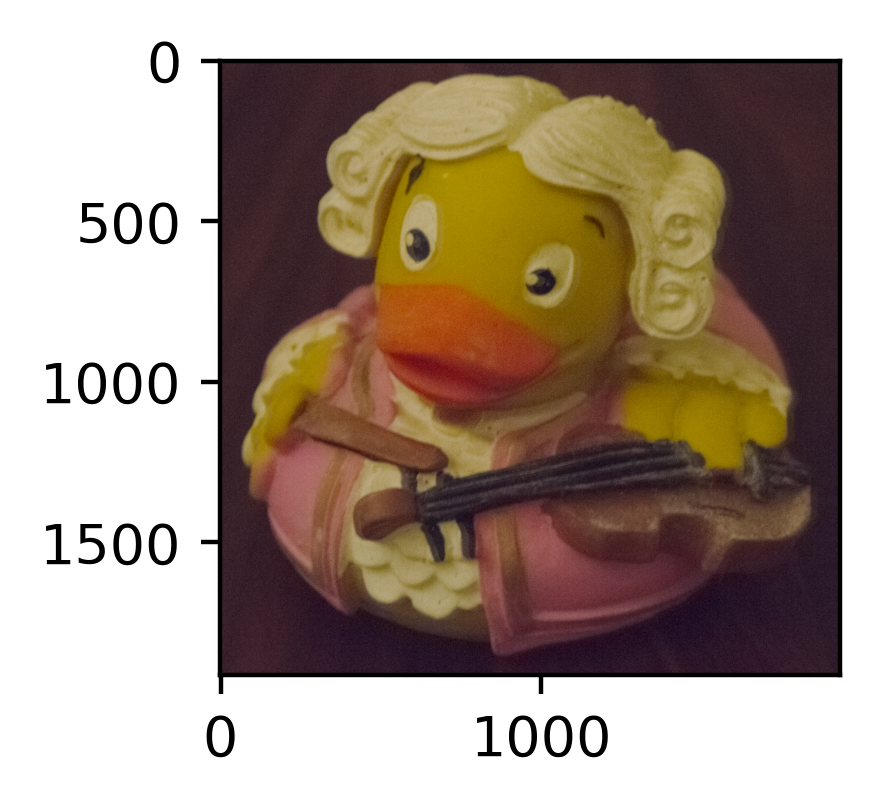

In [25]:
plt.imshow(skimage.exposure.adjust_gamma(duck_combined, 0.5, 1.0))

That is all for this part, the exercise continues in the other notebook. Before handing in the notebook, please clear all outputs to make the file smaller.